# Imports and Installations

In [1]:
import sys

!{sys.executable} -m pip install xgboost


In [2]:
import numpy as np #for handling arrays 
import pandas as pd #for handling dataframes 
# for building models 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
# for hyperparameter tuning 
from sklearn.model_selection import train_test_split, GridSearchCV
# for model evaluation 
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
# for visualzing results 
import matplotlib.pyplot as plt 
# to interact with hardware and save the final model 
import os
import joblib
# to display dataframes 
from IPython.display import display
# use the style available in seaborn library 
plt.style.use('seaborn')
import warnings
warnings.simplefilter(action='ignore')

C:\Users\kulpr\AppData\Local\Temp\ipykernel_23436\2445205404.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Constants

In [3]:
# create some constants 
RESULTS_SAVE_PATH = 'Results/'
MODEL_SAVE_PATH = 'Objects/Models/'
EVALUATION_FIGSIZE = (16,6)
EVALUATION_NROWS = 1
EVALUATION_NCOLS = 2
STATES = ['TX', 'CA', 'VA', 'NC', 'CO', 'FL', 'MA', 'MD']
TEST_SIZE = 0.3
RANDOM_STATE = 42
PREPROCESSED_FILE_PATH = 'preprocessed/'

In [4]:
# Fetch the data and store in the dictionary 
df_dict = dict(zip(STATES, [pd.read_csv(os.path.join(PREPROCESSED_FILE_PATH,f'{state}.csv')) for state in STATES]))


# Preparing data for model

In [5]:
#store X and y for each state in dictionary
X_dict = dict(zip(STATES,[df.drop(['price'], axis = 1) for df in df_dict.values()]))
y_dict = dict(zip(STATES,[df['price'] for df in df_dict.values()]))

In [6]:
# Create dictionaries for X_train, y_train, X_test and y_test 
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for state in STATES:
    # Subset X and y for each state
    X = X_dict[state]
    y = y_dict[state]
    # Perform train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=TEST_SIZE, random_state=RANDOM_STATE)
    #sc_X = StandardScaler()
    #X_train = sc_X.fit_transform(X_train)
    #X_test = sc_X.transform(X_test)
    # Store values in the dictionary for training models
    X_train_dict[state] = X_train
    X_test_dict[state] = X_test
    y_train_dict[state] = y_train
    y_test_dict[state] = y_test
    

In [7]:
# create a helper function
def summarize_model(model):
    model_r2_train_dict = {} #create a dictionary for r2 score of train set
    model_r2_test_dict = {} #create a dictionary for r2 score of test set
    model_mae_train_dict = {} #create a dictionary for mae of train set 
    model_mae_test_dict = {} #create a dictionary for mae of test set
    model_mse_train_dict = {}
    model_mse_test_dict = {}
    model_dict = {} #create a dictionary of models 
    for state in STATES:#loop through states
        model.fit(X_train_dict[state],y_train_dict[state]) #fit the model 
        model_dict[state] = model #store the model for that state in model dict
        model_train_preds = model.predict(X_train_dict[state]) #predict for train set 
        model_test_preds = model.predict(X_test_dict[state]) #predict for test set 
        model_r2_train_dict[state] = r2_score(y_true=y_train_dict[state], y_pred=model_train_preds) #calculate r2 for train set 
        model_r2_test_dict[state] = r2_score(y_true=y_test_dict[state], y_pred=model_test_preds) #calculate r2 for test set 
        model_mae_train_dict[state] = mean_absolute_error(y_true=y_train_dict[state],y_pred=model_train_preds) #calcaulte mae for train set
        model_mae_test_dict[state] = mean_absolute_error(y_true=y_test_dict[state], y_pred=model_test_preds) #calculate mae for test set 
        
    #store metrics in a dictionary
    metrics_dict = {
        'train r2':model_r2_train_dict,
        'test r2':model_r2_test_dict,
        'train mae':model_mae_train_dict,
        'test mae':model_mae_test_dict,
        
    }
    display(pd.DataFrame(metrics_dict))
    return model_dict, metrics_dict #return model and metrics 
        
        
        

In [8]:
dt_dict, dt_metrics = summarize_model(DecisionTreeRegressor())

,train r2,test r2,train mae,test mae
TX,0.990866,0.394338,10.075276,174.483125
CA,0.995716,0.583797,13.857716,331.334546
VA,0.994005,0.657063,13.252849,171.665451
NC,0.989033,0.226159,10.208794,163.968292
CO,0.988618,0.495758,14.891562,164.500345
FL,0.992773,0.244840,9.494881,208.898397
MA,0.991714,0.514976,15.026945,293.460480
MD,0.992503,0.633658,12.727190,139.730472


In [9]:
rf_dict, rf_metrics = summarize_model(RandomForestRegressor())

,train r2,test r2,train mae,test mae
TX,0.942830,0.636849,56.191844,144.717963
CA,0.958342,0.735733,108.965083,276.625905
VA,0.968922,0.794195,57.600605,143.158819
NC,0.934595,0.578415,51.281977,127.261089
CO,0.947691,0.696679,57.476212,137.393316
FL,0.934908,0.563370,64.724605,166.438623
MA,0.949183,0.697917,97.982402,240.771272
MD,0.958123,0.749503,51.852109,122.981512


In [10]:
# Adaboost Regression
adaboost_dict, adaboost_metrics = summarize_model(AdaBoostRegressor())

,train r2,test r2,train mae,test mae
TX,0.395507,0.376449,208.769728,216.502316
CA,0.282385,0.285737,523.383227,528.357371
VA,0.411515,0.377488,289.351416,298.369957
NC,0.318707,0.309843,184.468061,182.692807
CO,0.430277,0.415438,217.625040,225.482279
FL,0.280022,0.295497,247.040453,244.203119
MA,0.392331,0.346229,380.400899,392.532358
MD,0.397456,0.372061,224.876751,226.212734


In [11]:
# Gradient boosting regression 
gb_dict, gb_metrics = summarize_model(GradientBoostingRegressor())

,train r2,test r2,train mae,test mae
TX,0.571697,0.546324,165.993499,174.575125
CA,0.608653,0.591358,377.253333,392.015222
VA,0.721828,0.683490,191.392466,203.252390
NC,0.521947,0.479908,147.402795,152.040686
CO,0.630797,0.572669,165.441807,183.795838
FL,0.546716,0.498307,185.816356,195.497588
MA,0.646789,0.599225,286.838328,305.365515
MD,0.652800,0.605616,163.012150,168.173235


In [12]:
# XGBoost Regression 
xgb_dict, xgb_metrics = summarize_model(XGBRegressor(objective='reg:squarederror'))

,train r2,test r2,train mae,test mae
TX,0.748853,0.649089,120.673297,147.007331
CA,0.821670,0.749976,240.435080,288.016669
VA,0.889443,0.797813,111.833822,149.163984
NC,0.776975,0.578883,94.893603,129.697719
CO,0.857880,0.694193,95.659492,146.078540
FL,0.791869,0.579087,119.872334,167.049633
MA,0.869060,0.750085,164.354126,227.344709
MD,0.889423,0.740240,85.530995,126.606683


In [13]:
# create dictionaries for visualization 
model_dict = {
    
    'DT':dt_dict,
    'RF':rf_dict,
    'ADA':adaboost_dict,
    'GB':gb_dict,
    'XGB':xgb_dict
}
model_metrics = {
    
    'DT':dt_metrics,
    'RF':rf_metrics,
    'ADA':adaboost_metrics,
    'GB':gb_metrics,
    'XGB':xgb_metrics
}

In [14]:
# Create dictionaries for metrics for all models 
train_r2 = {}
test_r2 = {}
train_mae = {}
test_mae = {}

for model, metrics_dict in model_metrics.items():
    train_r2[model] = metrics_dict['train r2']
    test_r2[model] = metrics_dict['test r2']
    train_mae[model] = metrics_dict['train mae']
    test_mae[model] = metrics_dict['test mae']

In [15]:
# Convert them to dataframes 
train_r2 = pd.DataFrame(train_r2)
test_r2 = pd.DataFrame(test_r2)
train_mae = pd.DataFrame(train_mae)
test_mae = pd.DataFrame(test_mae)

In [16]:
# Change the column names for identification 
train_r2.columns = [col+'_train_r2' for col in train_r2.columns]
test_r2.columns = [col+'_test_r2' for col in test_r2.columns] 
train_mae.columns = [col+'_train_mae' for col in train_mae.columns]
test_mae.columns = [col+'_test_mae' for col in test_mae.columns]

In [17]:
# Create dataframe for plotting r2 score 
plot_r2 = pd.DataFrame()
for c1, c2 in zip(train_r2.columns, test_r2.columns):
    plot_r2[c1] = train_r2[c1]
    plot_r2[c2] = test_r2[c2]

In [18]:
# create dataframe for plotting mae 
plot_mae = pd.DataFrame()
for c1,c2 in zip(train_mae.columns, test_mae.columns):
    plot_mae[c1] = train_mae[c1]
    plot_mae[c2] = test_mae[c2]

In [19]:
# transpose the dataframes for easy plotting 
plot_r2 = plot_r2.T
plot_mae = plot_mae.T

In [20]:
# Reshape states to plot better 
states_plot = np.array(STATES).reshape(4,2)

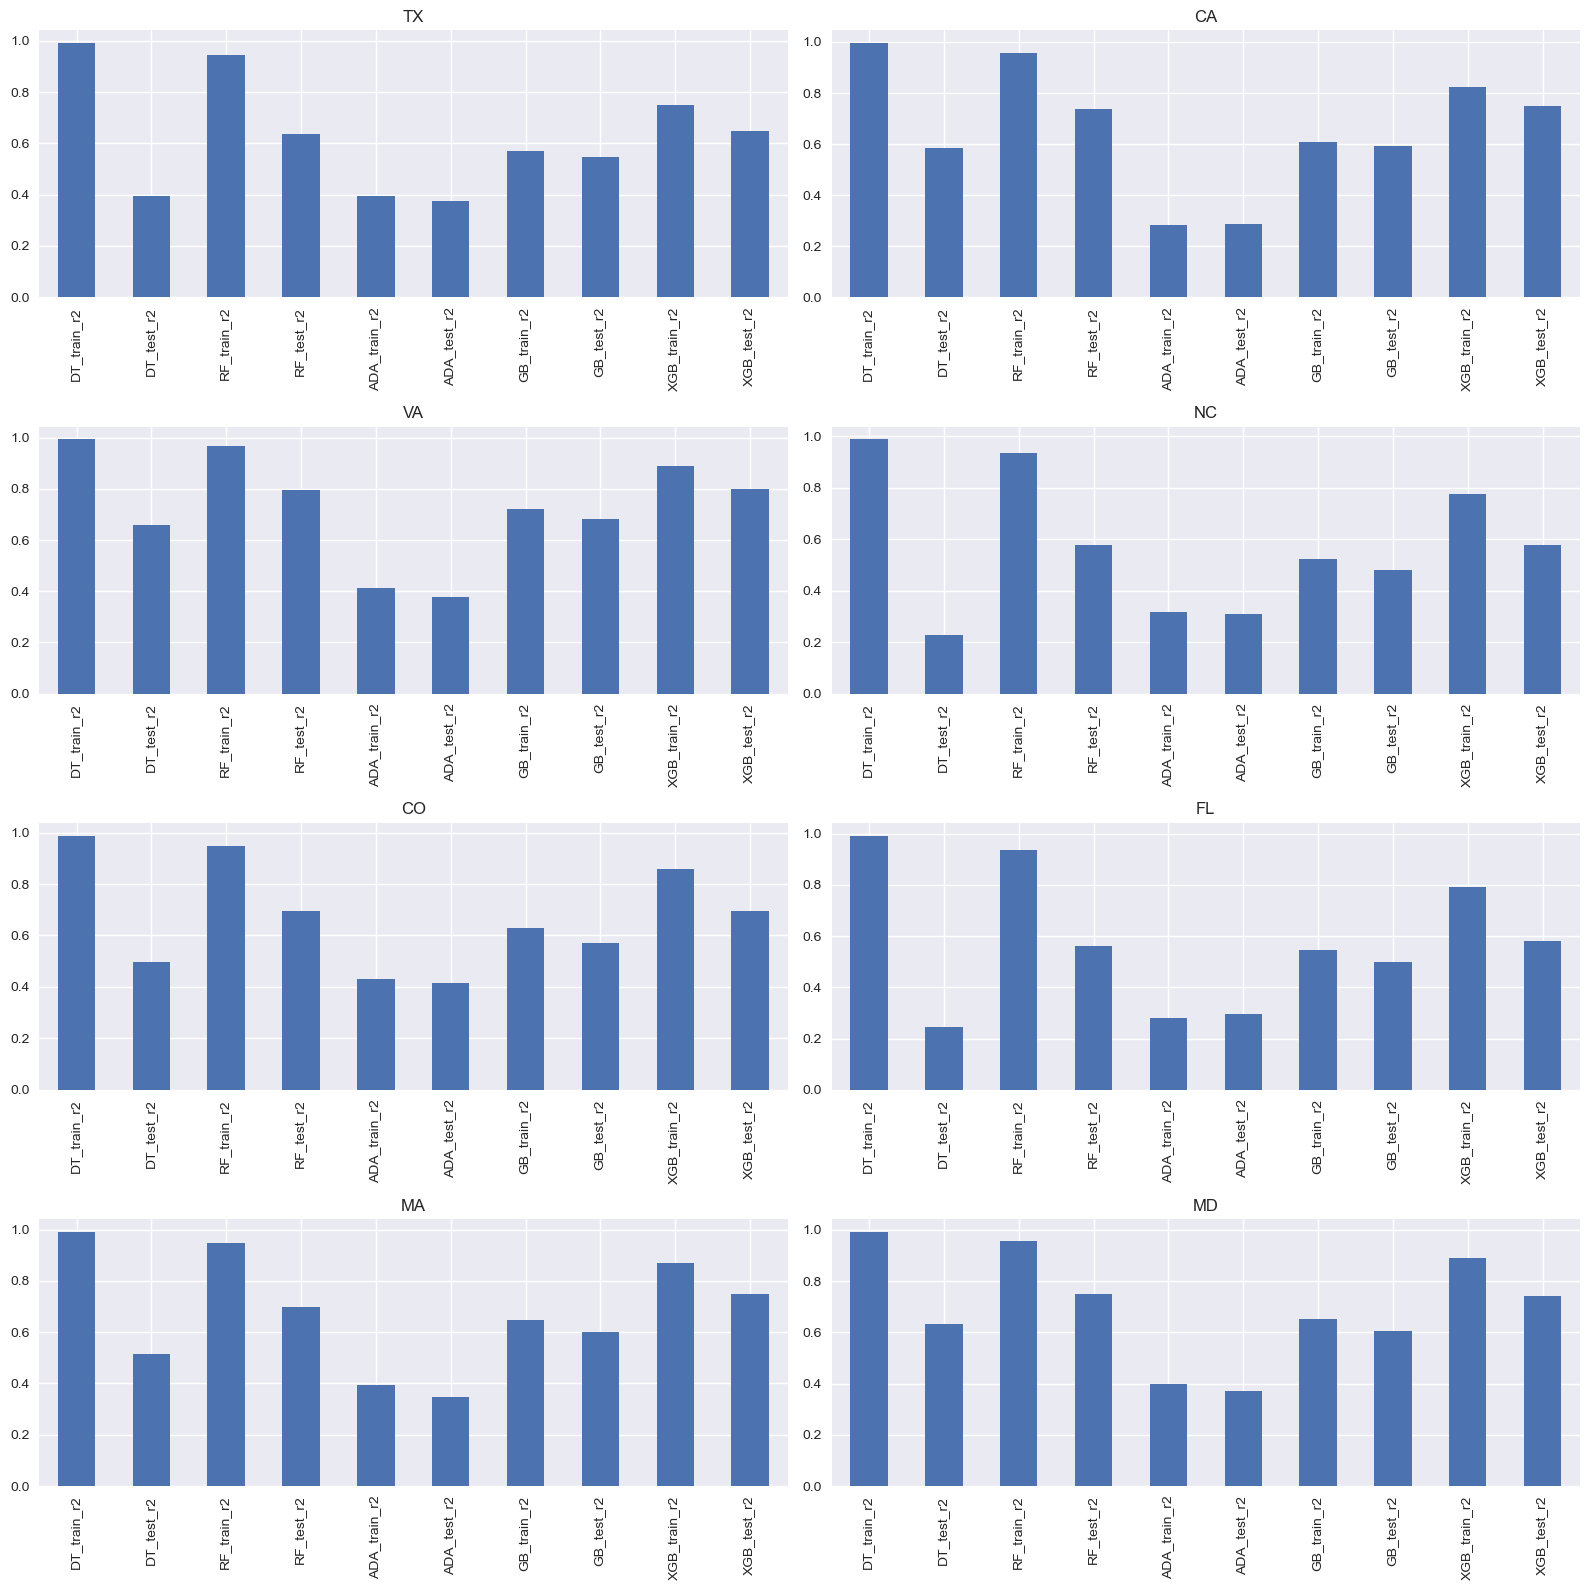

In [21]:
fig, ax = plt.subplots(figsize=(16,16),nrows=4,ncols=2) #create a 4*2 figure 
for i in range(4): #loop through rows 
    for j in range(2): #loop through columns 
        plot_r2[states_plot[i,j]].plot(kind='bar',ax=ax[i,j]) #plot the column  
        ax[i,j].set_title(states_plot[i,j]) #set title 
plt.tight_layout() #tight layout for avoiding overlap 
if not os.path.exists(RESULTS_SAVE_PATH): #check if path exists 
    os.makedirs(RESULTS_SAVE_PATH) #if not, create the path 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'all_models_r2.png')) #save the results 
plt.show() #show the plot 

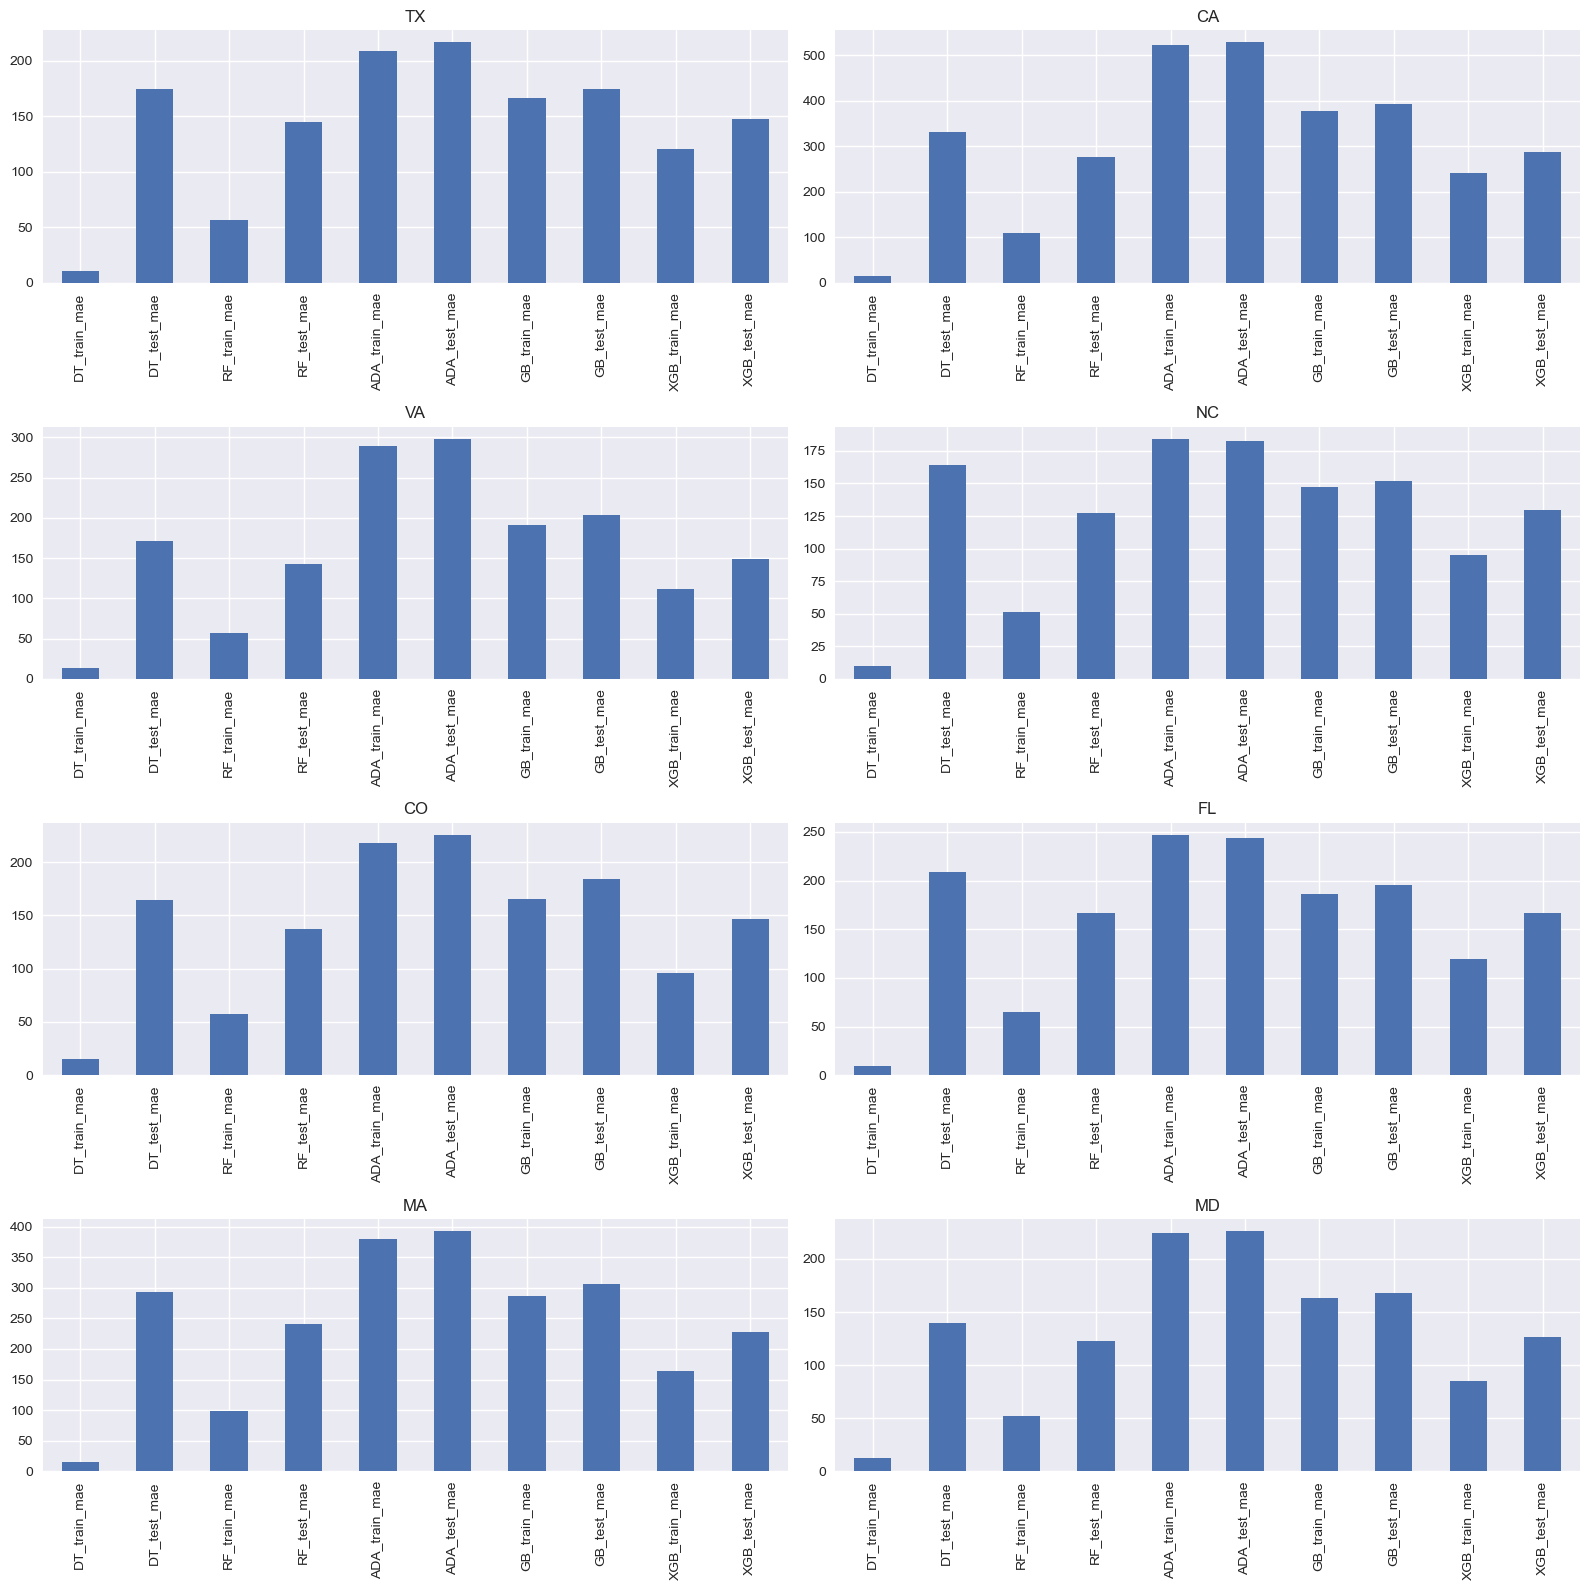

In [22]:
fig, ax = plt.subplots(figsize=(16,16),nrows=4,ncols=2) #create 4*2 figure 
for i in range(4): #loop through rows 
    for j in range(2): #loop through columns 
        plot_mae[states_plot[i,j]].plot(kind='bar',ax=ax[i,j]) #plot the column 
        ax[i,j].set_title(states_plot[i,j]) #set the title 
plt.tight_layout() #tight layout to avoud overlap 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'all_models_mae.png')) #save the figure 
plt.show() #show the figure 

In [23]:
# hyperparameter tuning 
param_tuning = {
        'learning_rate': [0.001,0.01,0.1],
        'max_depth': [3, 5, 7],
        'n_estimators' : [100, 200,300],
    }



In [24]:
# perform cross validation
xgb_validated_dict = {} #create a dictionary for validated xgboost model 
for state, model in xgb_dict.items(): #loop though  existing xgboost model 
    xgb_validated = GridSearchCV(model, param_tuning, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error') #perform cross validation
    xgb_validated.fit(X_train_dict[state], y_train_dict[state]) #fit the validated model 
    xgb_validated_dict[state] = xgb_validated #save the model in the dictionary 

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [25]:
# create a dictionary for metrics 
xgb_validated_metrics = {}
train_r2_dict = {}
test_r2_dict = {}
train_mae_dict = {}
test_mae_dict = {}
for state, model in xgb_validated_dict.items(): #loop through validated xgboost models 
    train_preds = model.predict(X_train_dict[state]) #predict on train set 
    test_preds = model.predict(X_test_dict[state]) #predict on test set 
    train_r2 = r2_score(y_true=y_train_dict[state],y_pred=train_preds) #calculate r2 on train set 
    test_r2 = r2_score(y_true=y_test_dict[state],y_pred=test_preds) #calculate r2 on test set 
    train_mae = mean_absolute_error(y_true=y_train_dict[state], y_pred=train_preds) #calculate mae on train set 
    test_mae = mean_absolute_error(y_true=y_test_dict[state],y_pred=test_preds) #calculate mae on test set 
    # store metrics in respective dictionaries 
    train_r2_dict[state] = train_r2 
    test_r2_dict[state] = test_r2
    train_mae_dict[state] = train_mae
    test_mae_dict[state] = test_mae
# create dictionary for storing metrics 
xgb_validated_metrics = {
    'train r2':train_r2_dict,
    'test r2':test_r2_dict,
    'train mae': train_mae_dict,
    'test mae':test_mae_dict
}

In [26]:
# convert metrics of xgboost and validated model to dataframe 
xgb_metrics_df = pd.DataFrame(xgb_metrics)
xgb_validated_metrics_df = pd.DataFrame(xgb_validated_metrics)

In [59]:
xgb_metrics_df

,train r2_xgb,test r2_xgb,train mae_xgb,test mae_xgb
TX,0.748853,0.649089,120.673297,147.007331
CA,0.821670,0.749976,240.435080,288.016669
VA,0.889443,0.797813,111.833822,149.163984
NC,0.776975,0.578883,94.893603,129.697719
CO,0.857880,0.694193,95.659492,146.078540
FL,0.791869,0.579087,119.872334,167.049633
MA,0.869060,0.750085,164.354126,227.344709
MD,0.889423,0.740240,85.530995,126.606683


In [60]:
xgb_validated_metrics_df

,train r2_xgb_val,test r2_xgb_val,train mae_xgb_val,test mae_xgb_val
TX,0.770999,0.657661,114.984617,144.838040
CA,0.832427,0.751257,234.120974,288.007948
VA,0.894827,0.800831,109.045262,147.978443
NC,0.796652,0.586628,90.237653,128.646608
CO,0.879529,0.704217,86.008437,141.200459
FL,0.795358,0.579583,117.939522,167.017042
MA,0.882743,0.754659,157.308651,223.374630
MD,0.893775,0.749232,82.989169,123.399170


In [27]:
# rename columns for easy interpretation 
xgb_metrics_df.columns = [col + '_xgb' for col in xgb_metrics_df.columns]
xgb_validated_metrics_df.columns = [col + '_xgb_val' for col in xgb_validated_metrics_df.columns]

In [28]:
# create a final metrics dataframe for plotting 
final_metrics_df = pd.DataFrame()
for c1, c2 in zip(xgb_metrics_df.columns, xgb_validated_metrics_df.columns):
    final_metrics_df[c1] = xgb_metrics_df[c1]
    final_metrics_df[c2] = xgb_validated_metrics_df[c2]

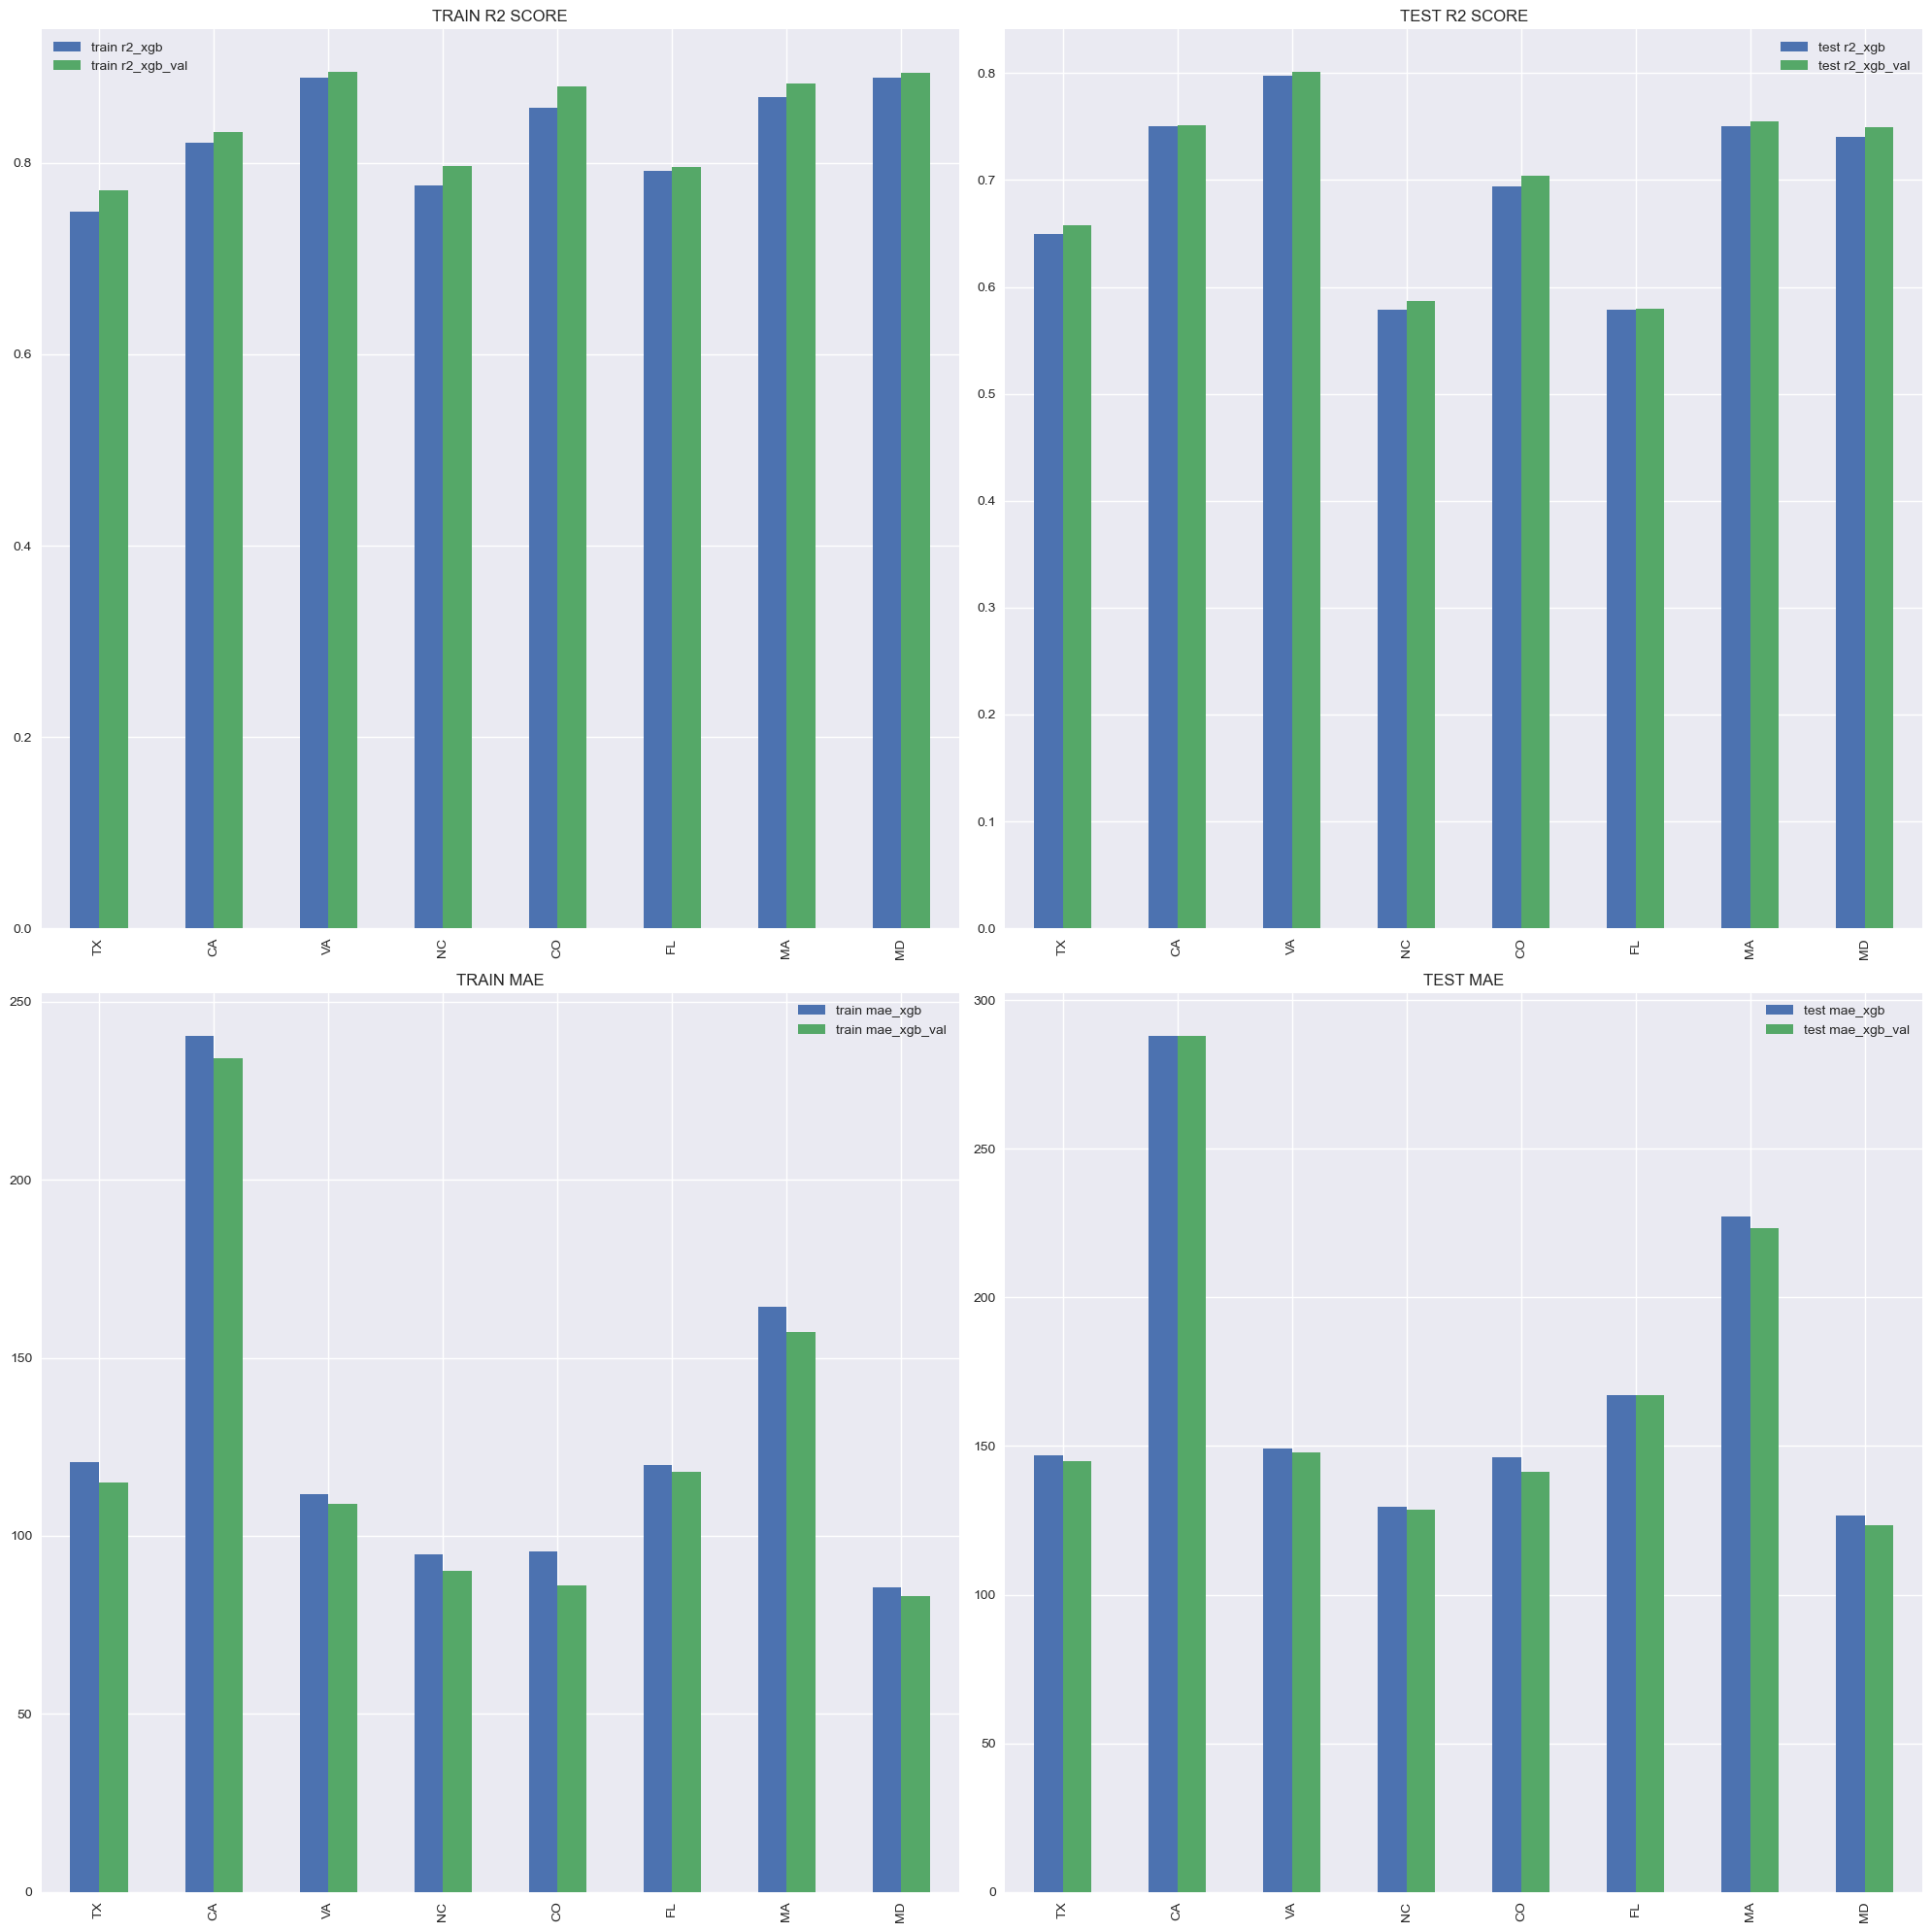

In [29]:
fig, ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2) #create a 2*2 figure 
final_metrics_df[['train r2_xgb', 'train r2_xgb_val']].plot(kind='bar',ax=ax[0,0],title='TRAIN R2 SCORE') #plot train r2 for both models 
final_metrics_df[['test r2_xgb', 'test r2_xgb_val']].plot(kind='bar',ax=ax[0,1], title='TEST R2 SCORE') #plot test r2 for both models 
final_metrics_df[['train mae_xgb', 'train mae_xgb_val']].plot(kind='bar', ax=ax[1,0], title='TRAIN MAE') #plot train mae for both models 
final_metrics_df[['test mae_xgb', 'test mae_xgb_val']].plot(kind='bar', ax=ax[1,1],title='TEST MAE') #plot test mae for both models 
plt.tight_layout() #tight layout to avoid overlap 
if not os.path.exists(RESULTS_SAVE_PATH): #check if the path exists 
        os.makedirs(RESULTS_SAVE_PATH) #if not then make the path 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'hyperparameter_tuning.png')) #save the figure 
plt.show() #show the figure 

In [63]:
# save the models after fitting them on entire dataset 
for state in STATES:
    if not os.path.exists(MODEL_SAVE_PATH):
        os.makedirs(MODEL_SAVE_PATH)
    xgb_model = XGBRegressor(objective='reg:squarederror')
    xgb_model.fit(X_dict[state], y_dict[state])
    joblib.dump(xgb_model, os.path.join(MODEL_SAVE_PATH, f'{state}_model.pkl'))